In [ ]:
from docx import Document
import pandas as pd
from pandas import unique
from typeguard.importhook import optimized_cache_from_source


def is_bold(run):
    """Check if a text run is bolded."""
    return run.bold

def extract_articles(doc):
    titles, authors, times, descriptions = [], [], [], []
    current_title = current_author = current_time = None
    current_desc = []

    for paragraph in doc.paragraphs:
        text = paragraph.text.strip()

        # Check if paragraph is a TITLE (has bold runs)
        is_title = any(is_bold(run) for run in paragraph.runs)

        if is_title:
            # Save previous article if exists
            if current_title and current_author and current_time:
                titles.append(current_title)
                authors.append(current_author)
                times.append(current_time)
                descriptions.append(" ".join(current_desc))

            # Reset for new article
            current_title = text
            current_author = current_time = None
            current_desc = []

        # Detect AUTHOR (starts with "By")
        elif text.startswith("By "):
            current_author = text.replace("By ", "").strip()

        # Detect TIME (contains "GMT+8" or "Updated on")
        elif "GMT+8" in text or "Updated on" in text:
            current_time = text.split("Updated on")[0].strip()

        # Collect DESCRIPTION (non-title, non-metadata text)
        elif text and not is_title:
            current_desc.append(text)

    # Add the last article
    if current_title and current_author and current_time:
        titles.append(current_title)
        authors.append(current_author)
        times.append(current_time)
        descriptions.append(" ".join(current_desc))

    return pd.DataFrame({
        "Title": titles,
        "Author": authors,
        "Time": times,
        "Description": descriptions
    })

# Load the document
doc = Document("data/News Articles/Amy/3Mar25_News_Amy.docx")

# Extract and export data
df = extract_articles(doc)
df.to_excel("data/News Articles/Amy/Articles_combined.xlsx", index=False)
print(f"Extracted {len(df)} articles. Excel file saved!")

In [ ]:
import os
from docx import Document
import pandas as pd

def is_bold(run):
    """Check if a text run is bolded."""
    return run.bold

def extract_articles(doc):
    """Extract articles from a single DOCX file."""
    titles, authors, times, descriptions = [], [], [], []
    current_title = current_author = current_time = None
    current_desc = []

    for paragraph in doc.paragraphs:
        text = paragraph.text.strip()

        # Check if paragraph is a TITLE (has bold runs)
        is_title = any(is_bold(run) for run in paragraph.runs)

        if is_title:
            # Save previous article if exists
            if current_title and current_author and current_time:
                titles.append(current_title)
                authors.append(current_author)
                times.append(current_time)
                descriptions.append(" ".join(current_desc))

            # Reset for new article
            current_title = text
            current_author = current_time = None
            current_desc = []

        # Detect AUTHOR (starts with "By")
        elif text.startswith("By "):
            current_author = text.replace("By ", "").strip()

        # Detect TIME (contains "GMT+8" or "Updated on")
        elif "GMT+8" in text or "Updated on" in text:
            current_time = text.split("Updated on")[0].strip()

        # Collect DESCRIPTION (non-title, non-metadata text)
        elif text and not is_title:
            current_desc.append(text)

    # Add the last article
    if current_title and current_author and current_time:
        titles.append(current_title)
        authors.append(current_author)
        times.append(current_time)
        descriptions.append(" ".join(current_desc))

    return pd.DataFrame({
        "Title": titles,
        "Author": authors,
        "Time": times,
        "Description": descriptions,
        "Source File": os.path.basename(doc_path)  # Track which file each article came from
    })

# Main processing
all_articles = pd.DataFrame()
folder_path = "data/News Articles/Amy/Teams"  # Replace with your folder path

# Process each DOCX file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".docx"):
        doc_path = os.path.join(folder_path, filename)
        try:
            print(f"Processing {filename}...")
            doc = Document(doc_path)
            df = extract_articles(doc)
            all_articles = pd.concat([all_articles, df], ignore_index=True)
        except Exception as e:
            print(f"Error processing {filename}: {e}")

# Save combined results
output_path = "data/News Articles/Amy/Articles_combined.xlsx"
all_articles.to_excel(output_path, index=False)
print(f"\nDone! Combined {len(all_articles)} articles from {len(os.listdir(folder_path))} files.")
print(f"Saved to: {output_path}")


In [11]:
import pandas as pd
import re
from datetime import datetime

data = pd.read_excel("data/News Articles/Amy/Articles_combined.xlsx")

# Sample data (replace with your actual data)
timestamps = data["Time"]

def clean_timestamp(timestamp):
    try:
        # Standardize different formats
        if "GMT+8" in timestamp:
            if "." in timestamp:  # Format: "2025.3.3 at GMT+8 07:02"
                date_part, time_part = timestamp.split(" at GMT+8 ")
                year, month, day = date_part.split(".")
                time_obj = datetime.strptime(time_part, "%H:%M").time()
            else:  # Format: "June 2, 2025 at 6:30 PM GMT+8"
                dt_str = timestamp.replace(" at ", " ").replace(" GMT+8", "")
                dt_obj = datetime.strptime(dt_str, "%B %d, %Y %I:%M %p")
                return dt_obj.isoformat()
        else:
            # Handle other formats if they exist
            pass

        # Create datetime object
        dt_obj = datetime(int(year), int(month), int(day),
                         time_obj.hour, time_obj.minute)

        return dt_obj.isoformat()

    except Exception as e:
        print(f"Error parsing '{timestamp}': {e}")
        return None

# Create DataFrame
df = pd.DataFrame({"Original": timestamps})
df["Standardized"] = df["Original"].apply(clean_timestamp)

# Convert to pandas datetime
df["DateTime"] = pd.to_datetime(df["Standardized"]).dt.tz_localize("Asia/Singapore")
df["DateTime"] = df["DateTime"].dt.tz_convert("US/Eastern")
data['Datetime'] = df['DateTime'].dt.tz_localize(None)

data.to_excel("data/News Articles/Amy/Articles_combined.xlsx")

In [39]:
# Python libraries

# 1.DistilBERT
from transformers import pipeline
classifier = pipeline('sentiment-analysis', model='distilbert-base-uncased-finetuned-sst-2-english')

def DistilBERT(sentence):
    cl = classifier(sentence)
    t = cl[0]['label']
    score = cl[0]['score']
    label = 'NEU'
    if t == 'POSITIVE':
        label = 'POS'
    elif t == 'NEGATIVE':
        label = 'NEG'
    return (label, score)

# 2.Flair
from flair.data import Sentence
from flair.nn import Classifier
tagger = Classifier.load('sentiment')

def Flair(sentence):
    sentence = Sentence(sentence)
    tagger.predict(sentence)
    cl = sentence.labels[0]
    t = cl.value
    label = 'NEU'
    if t == 'POSITIVE':
        label = 'POS'
    elif t == 'NEGATIVE':
        label = 'NEG'
    score = cl.score
    return (label, score)

# 3.FinBERT
classifier1 = pipeline("sentiment-analysis", model="ProsusAI/finbert")

def FinBERT(sentence):
    cl = classifier(sentence)
    t = cl[0]['label']
    score = cl[0]['score']
    label = 'NEU'
    if t == 'positive':
        label = 'POS'
    elif t == 'negative':
        label = 'NEG'
    return (label, score)

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
def Vader(sentence):
    return analyzer.polarity_scores(sentence)['compound']

C:\Users\Jay Tai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Users\Jay Tai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [40]:
data['Vader Title Score'] = data['Title'].apply(Vader)
data['Vader Description Score'] = data['Description'].apply(Vader)

data['Flair Title Label'] = data['Title'].apply(Flair).apply(lambda x:x[0])
data['Flair Title Score'] = data['Title'].apply(Flair).apply(lambda x:x[1])
data['Flair Description Label'] = data['Description'].apply(Flair).apply(lambda x:x[0])
data['Flair Description Score'] = data['Description'].apply(Flair).apply(lambda x:x[1])

data['DistilBERT Title Label'] = data['Title'].apply(DistilBERT).apply(lambda x:x[0])
data['DistilBERT Title Score'] = data['Title'].apply(DistilBERT).apply(lambda x:x[1])
data['DistilBERT Description Label'] = data['Description'].apply(DistilBERT).apply(lambda x:x[0])
data['DistilBERT Description Score'] = data['Description'].apply(DistilBERT).apply(lambda x:x[1])

data['FinBERT Title Label'] = data['Title'].apply(FinBERT).apply(lambda x:x[0])
data['FinBERT Title Score'] = data['Title'].apply(FinBERT).apply(lambda x:x[1])
data['FinBERT Description Label'] = data['Description'].apply(FinBERT).apply(lambda x:x[0])
data['FinBERT Description Score'] = data['Description'].apply(FinBERT).apply(lambda x:x[1])

In [41]:
# Simple ML models

import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    if not isinstance(text, str) or text is None:
        return ""
    # Remove extra spaces and normalize
    text = ' '.join(text.split())
    tokens = word_tokenize(text.lower())
    # Retain alphanumeric tokens to keep numbers (e.g., "20%")
    cleaned_tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalnum() and token not in stop_words]
    return ' '.join(cleaned_tokens)

# data which they were trained on
df1 = pd.read_csv("data/News Articles/headlines_with_sentiment (grok).csv")
df1['Headline'] = df1['Headline'].apply(preprocess)
X = df1['Headline']
y = df1['Sentiment_label']

# 1.SVM
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.svm import LinearSVC
pipeline_svc = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model', LinearSVC())
]); pipeline_svc.fit(X, y)

# 2.KNN
from sklearn.neighbors import KNeighborsClassifier
pipeline_knn = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('model', KNeighborsClassifier())
]); pipeline_knn.fit(X, y)

# 3.GBDT
from sklearn.ensemble import GradientBoostingClassifier
pipeline_GBDT = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('model', GradientBoostingClassifier())
]); pipeline_GBDT.fit(X, y)

# LR
from sklearn.linear_model import LogisticRegression
pipeline_LR = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('model', LogisticRegression())
]);pipeline_LR.fit(X,y)

# M NB
from sklearn.naive_bayes import MultinomialNB
pipeline_NB = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('model', MultinomialNB())
]); pipeline_NB.fit(X,y)

# RF
from sklearn.ensemble import RandomForestClassifier
pipeline_RF = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('model', RandomForestClassifier())
]); pipeline_RF.fit(X,y)

[nltk_data] Downloading package wordnet to C:\Users\Jay
[nltk_data]     Tai\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Jay
[nltk_data]     Tai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Jay
[nltk_data]     Tai\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,steps,"[('vect', ...), ('tfidf', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [44]:
data['Title_processed'] = data['Title'].apply(preprocess)
data['Desc_processed'] = data['Description'].apply(preprocess)

data['SVC Title Label'] = pipeline_svc.predict(data['Title_processed'])
data['SVC Description Label'] = pipeline_svc.predict(data['Desc_processed'])

data['LR Title Label'] = pipeline_LR.predict(data['Title_processed'])
data['LR Title Score'] = pipeline_LR.predict_proba(data['Title_processed']).max(axis=1)
data['LR Description Label'] = pipeline_LR.predict(data['Desc_processed'])
data['LR Description Score'] = pipeline_LR.predict_proba(data['Desc_processed']).max(axis=1)

data['NB Title Label'] = pipeline_NB.predict(data['Title_processed'])
data['NB Title Score'] = pipeline_NB.predict_proba(data['Title_processed']).max(axis=1)
data['NB Description Label'] = pipeline_NB.predict(data['Desc_processed'])
data['NB Description Score'] = pipeline_NB.predict_proba(data['Desc_processed']).max(axis=1)

data['GBDT Title Label'] = pipeline_GBDT.predict(data['Title_processed'])
data['GBDT Title Score'] = pipeline_GBDT.predict_proba(data['Title_processed']).max(axis=1)
data['GBDT Description Label'] = pipeline_GBDT.predict(data['Desc_processed'])
data['GBDT Description Score'] = pipeline_GBDT.predict_proba(data['Desc_processed']).max(axis=1)

data['RF Title Label'] = pipeline_RF.predict(data['Title_processed'])
data['RF Title Score'] = pipeline_RF.predict_proba(data['Title_processed']).max(axis=1)
data['RF Description Label'] = pipeline_RF.predict(data['Desc_processed'])
data['RF Description Score'] = pipeline_RF.predict_proba(data['Desc_processed']).max(axis=1)

data['KNN Title Label'] = pipeline_knn.predict(data['Title_processed'])
data['KNN Title Score'] = pipeline_knn.predict_proba(data['Title_processed']).max(axis=1)
data['KNN Description Label'] = pipeline_knn.predict(data['Desc_processed'])
data['KNN Description Score'] = pipeline_knn.predict_proba(data['Desc_processed']).max(axis=1)

In [45]:
data.to_excel("data/News Articles/Amy/Articles_combined.xlsx")

In [52]:
new = data.iloc[: , 6:21].copy()
new1 = data.iloc[:, 23:].copy()
n = pd.concat([new, new1], axis=1)
n.to_csv('data/News Articles/Amy/Article_sentiments.csv')

In [23]:
import pandas as pd
df = pd.read_csv('Data/Stock Data/SnP futures intraday w Sentiments.csv')

In [24]:
df = df.dropna()
df.info

<bound method DataFrame.info of                  Datetime  Unnamed: 0  Vader Title Score  \
0     2025-02-10 00:16:00          66            -0.3400   
1     2025-02-10 03:56:00          65             0.3818   
2     2025-02-10 08:44:00          64             0.0000   
3     2025-02-10 09:19:00          63            -0.3612   
4     2025-02-10 12:04:00          70             0.0000   
...                   ...         ...                ...   
1690  2025-06-25 20:32:00        1690             0.0000   
1691  2025-06-25 20:45:00        1691             0.0000   
1692  2025-06-25 21:15:00        1689             0.0000   
1693  2025-06-25 21:55:00        1692             0.3818   
1694  2025-06-25 22:18:00        1688             0.4404   

      Vader Description Score  Flair Title Label  Flair Title Score  \
0                     -0.0772                  1           0.891094   
1                      0.9360                  1           0.977796   
2                      0.7906     

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

y = df['PriceDiff30min']
features = [
    'Vader Title Score', 'Vader Description Score',
    'Flair Title Score', 'Flair Description Score',
    'DistilBERT Title Score', 'DistilBERT Description Score',
    'FinBERT Title Score', 'FinBERT Description Score',
    'LR Title Score', 'LR Description Score',
    'NB Title Score', 'NB Description Score',
    'GBDT Title Score', 'GBDT Description Score',
    'RF Title Score', 'RF Description Score',
    'KNN Title Score', 'KNN Description Score'
]

X = df[features]
y = (y > 0).astype(int)
model = DecisionTreeClassifier()
model.fit(X, y)

feature_importances = model.feature_importances_

# Assuming feature_names is a list of your feature column names
feature_names = X.columns.tolist()

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)



# print(f"Coefficients: {model.coef_}")
# print(f"Intercept: {model.intercept_}")

                         Feature  Importance
1        Vader Description Score    0.097353
9           LR Description Score    0.084661
15          RF Description Score    0.076989
2              Flair Title Score    0.072090
14                RF Title Score    0.070738
11          NB Description Score    0.066880
5   DistilBERT Description Score    0.059056
10                NB Title Score    0.058939
8                 LR Title Score    0.055710
12              GBDT Title Score    0.054765
3        Flair Description Score    0.054279
7      FinBERT Description Score    0.051645
6            FinBERT Title Score    0.048376
0              Vader Title Score    0.040062
13        GBDT Description Score    0.035226
4         DistilBERT Title Score    0.033770
17         KNN Description Score    0.023890
16               KNN Title Score    0.015570


In [20]:
label_cols = [col for col in df.columns if 'Label' in col and 'Score' not in col]

results = []

for label in label_cols:
    print(set(df[label]))

{1, -1}
{1, -1}
{1, -1}
{1, -1}
{0}
{0}
{0, 1, -1}
{0, 1, -1}
{1, -1}
{1, -1}
{1, -1}
{0, 1, -1}
{0, 1, -1}
{0, 1, -1}
{0, 1, -1}
{0, 1, -1}
{0, 1, -1}
{0, 1, -1}


In [25]:
#Checking for label accuracy

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

# Create binary target (1 if price increased, 0 otherwise)
df['PriceUp'] = (df['PriceDiff30min'] > 0).astype(int)

# Get all label columns (excluding scores)
label_cols = [col for col in df.columns if 'Label' in col and 'Score' not in col]

results = []

for label in label_cols:
    t = (df[label]>0).astype(int)
    # Calculate simple accuracy
    accuracy = accuracy_score(df['PriceUp'], t)

    # Calculate precision/recall components
    tn, fp, fn, tp = confusion_matrix(df['PriceUp'], t).ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    results.append({
        'Label': label,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0,
        'True_Positive': tp,
        'True_Negative': tn,
        'Positive_Count': t.sum()
    })

results_df = pd.DataFrame(results).sort_values('Accuracy', ascending=False)

C:\Users\Jay Tai\AppData\Local\Temp\ipykernel_23328\2918024437.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, y='Label', x='Accuracy', palette='viridis')


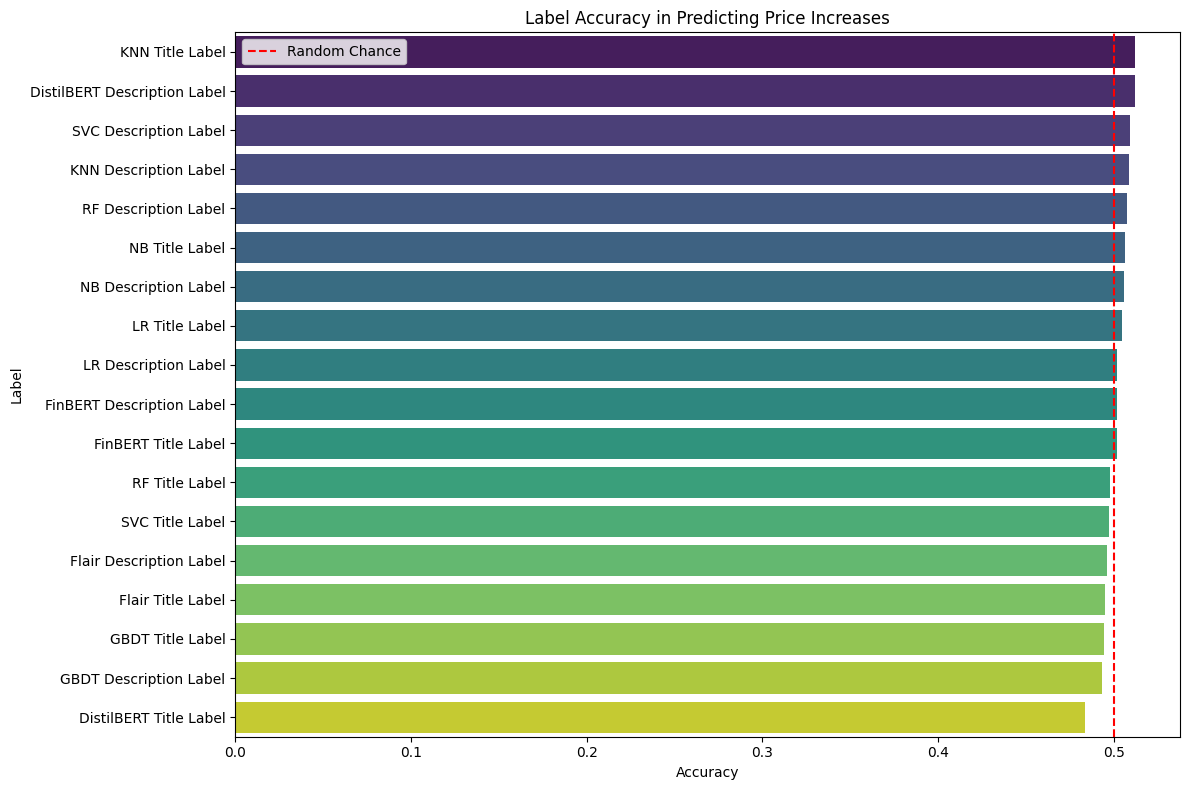

In [26]:
plt.figure(figsize=(12, 8))
sns.barplot(data=results_df, y='Label', x='Accuracy', palette='viridis')
plt.title('Label Accuracy in Predicting Price Increases')
plt.axvline(0.5, color='red', linestyle='--', label='Random Chance')
plt.legend()
plt.tight_layout()
plt.show()

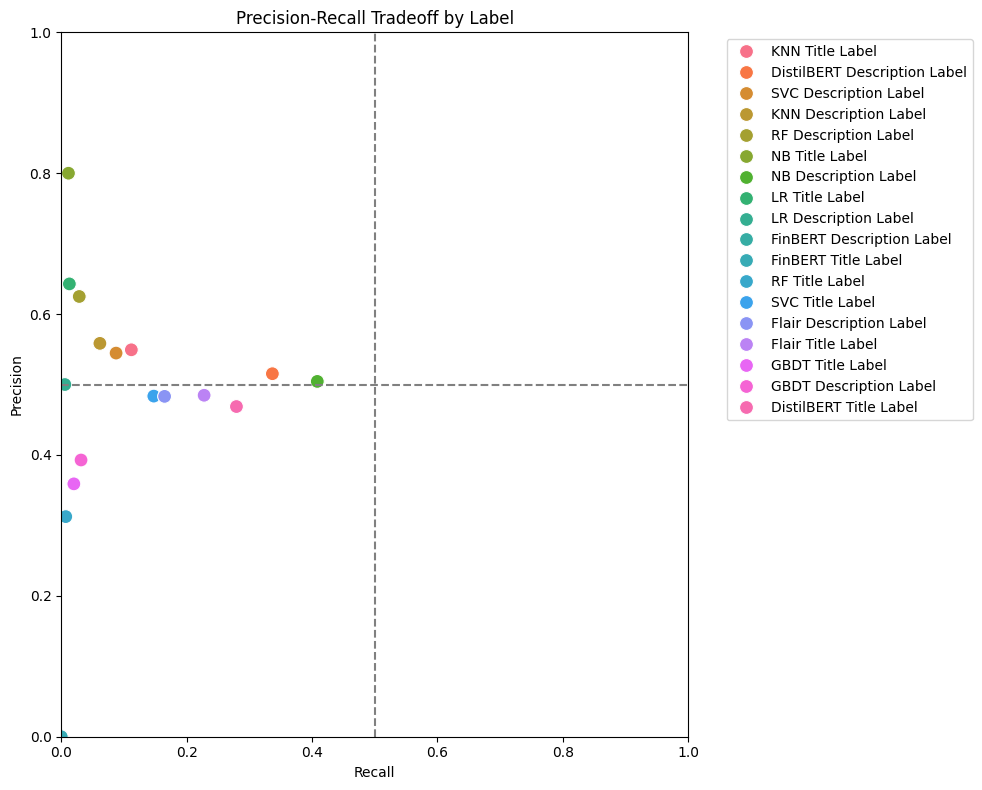

In [27]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=results_df, x='Recall', y='Precision', hue='Label', s=100)
plt.title('Precision-Recall Tradeoff by Label')
plt.axhline(0.5, color='grey', linestyle='--')
plt.axvline(0.5, color='grey', linestyle='--')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

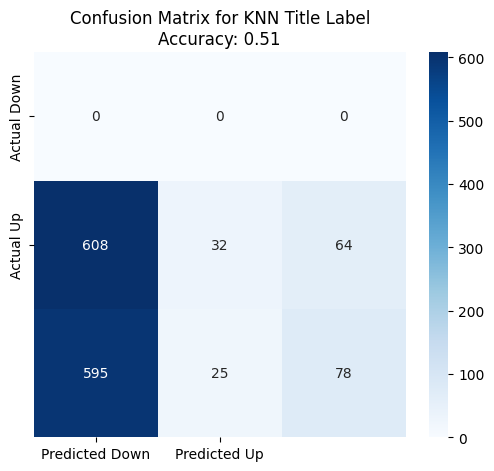

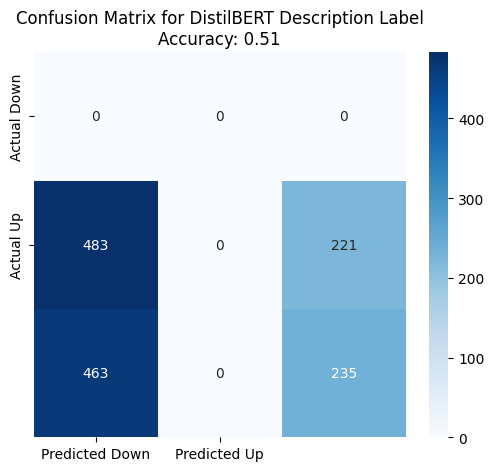

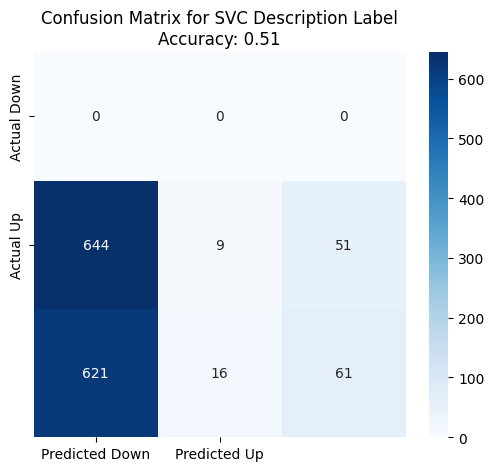

In [28]:
top_n = 3  # Show top 3 performers
top_labels = results_df.head(top_n)['Label'].values

for label in top_labels:
    cm = confusion_matrix(df['PriceUp'], df[label])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Down', 'Predicted Up'],
                yticklabels=['Actual Down', 'Actual Up'])
    plt.title(f'Confusion Matrix for {label}\nAccuracy: {results_df[results_df["Label"]==label]["Accuracy"].values[0]:.2f}')
    plt.show()

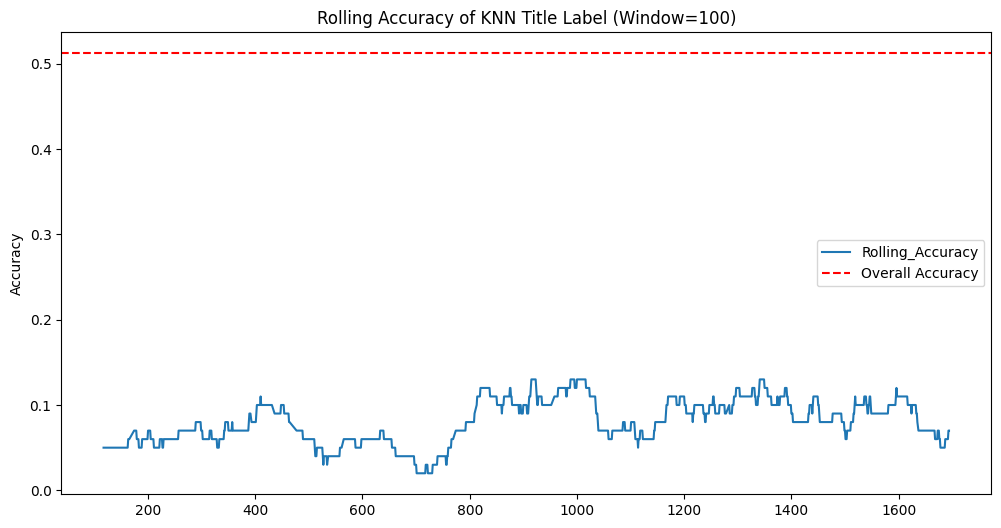

In [29]:
# For the top performing label
best_label = results_df.iloc[0]['Label']

# Calculate rolling accuracy
window_size = 100  # Adjust based on your data density
df['Rolling_Accuracy'] = df[best_label].rolling(window_size).apply(
    lambda x: accuracy_score(df['PriceUp'].loc[x.index], x)
)

plt.figure(figsize=(12, 6))
df['Rolling_Accuracy'].plot()
plt.axhline(results_df.iloc[0]['Accuracy'], color='red', linestyle='--', label='Overall Accuracy')
plt.title(f'Rolling Accuracy of {best_label} (Window={window_size})')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [31]:
#Checking for label accuracy

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

# Create binary target (1 if price increased, 0 otherwise)
df['PriceDown'] = (df['PriceDiff30min'] < 0).astype(int)

# Get all label columns (excluding scores)
label_cols = [col for col in df.columns if 'Label' in col and 'Score' not in col]

results = []

for label in label_cols:
    t = (df[label]<0).astype(int)
    # Calculate simple accuracy
    accuracy = accuracy_score(df['PriceDown'], t)

    # Calculate precision/recall components
    tn, fp, fn, tp = confusion_matrix(df['PriceDown'], t).ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    results.append({
        'Label': label,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0,
        'True_Positive': tp,
        'True_Negative': tn,
        'Positive_Count': t.sum()
    })

results_df = pd.DataFrame(results).sort_values('Accuracy', ascending=False)

C:\Users\Jay Tai\AppData\Local\Temp\ipykernel_23328\2918024437.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, y='Label', x='Accuracy', palette='viridis')


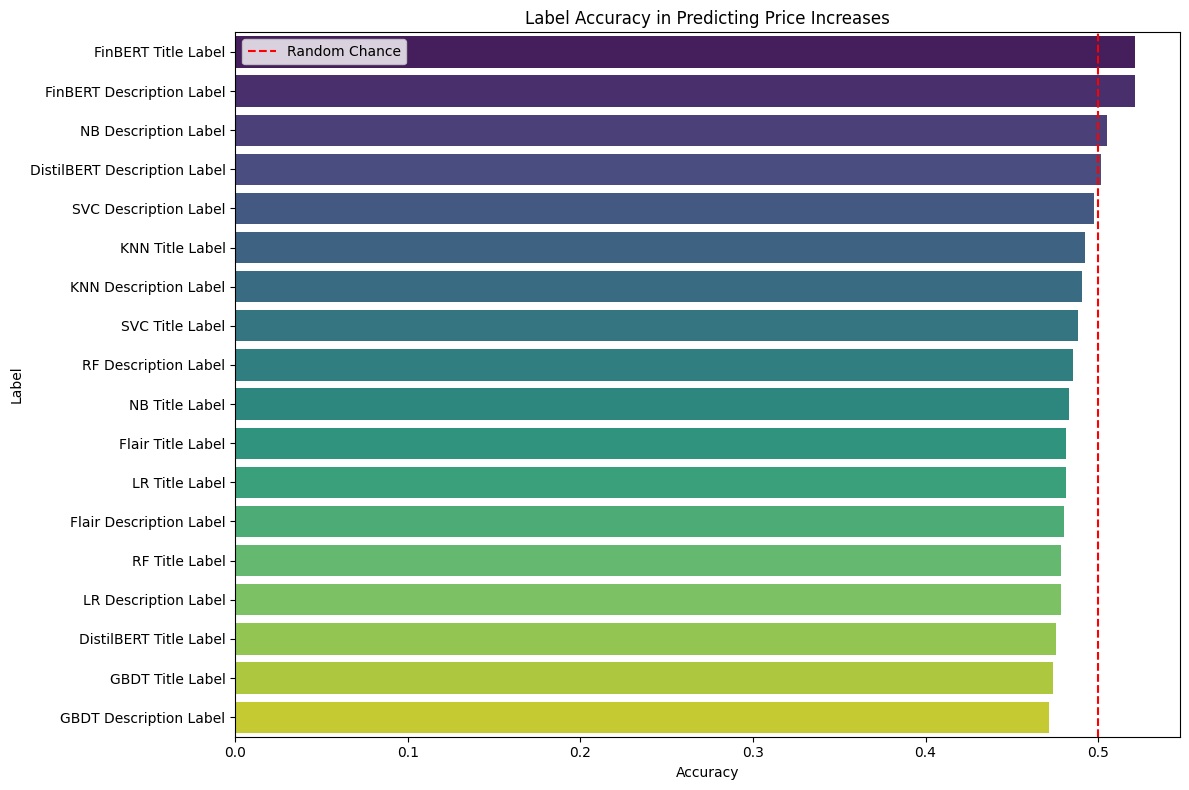

In [32]:
plt.figure(figsize=(12, 8))
sns.barplot(data=results_df, y='Label', x='Accuracy', palette='viridis')
plt.title('Label Accuracy in Predicting Price Increases')
plt.axvline(0.5, color='red', linestyle='--', label='Random Chance')
plt.legend()
plt.tight_layout()
plt.show()

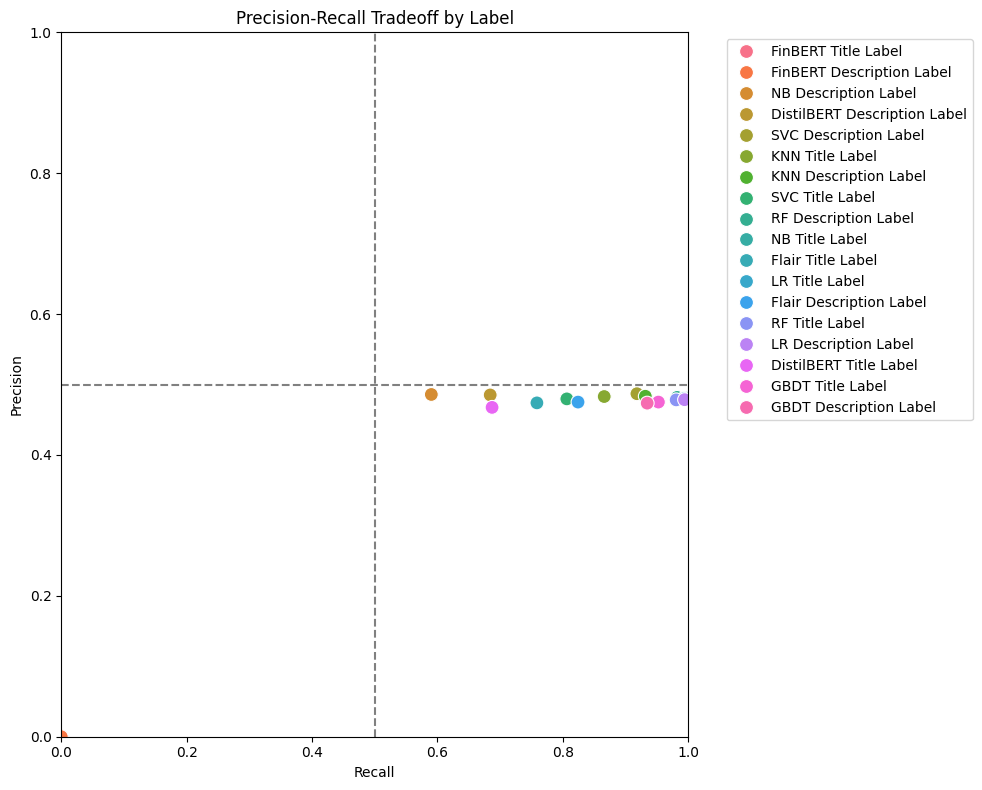

In [33]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=results_df, x='Recall', y='Precision', hue='Label', s=100)
plt.title('Precision-Recall Tradeoff by Label')
plt.axhline(0.5, color='grey', linestyle='--')
plt.axvline(0.5, color='grey', linestyle='--')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#NB, Distilbert, SVC desc

Coefficients: [[ 0.04058661  0.1255502  -0.0275048   0.11158972]]
Intercept: [0.13453604]
[0.49298388 0.49102217 0.51230628 ... 0.51172785 0.51464286 0.48376926]


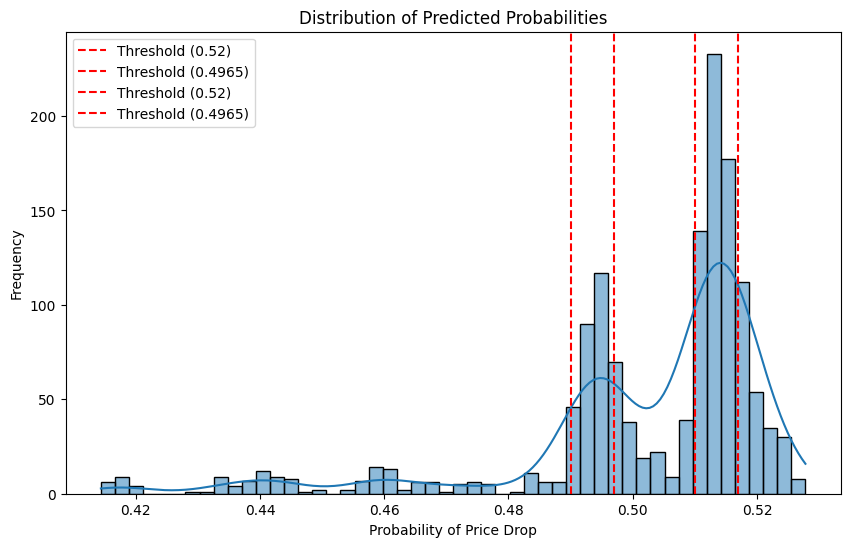

In [74]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

y = df['PriceDiff30min']
features = [ 'DistilBERT Description Label', 'KNN Description Label', 'KNN Title Label', 'SVC Description Label'
    'DistilBERT Description Score', 'KNN Description Score', 'KNN Title Score'
]

d = pd.DataFrame({
    'Distil': df['DistilBERT Description Label'] * df['DistilBERT Description Score'],
    'KNN Title': df['KNN Description Label'] * df['NB Description Score'],
    'KNN Desc': df['KNN Description Label'] * df['KNN Description Score'],
    'SVC': df['SVC Description Label']
})
X = d
y = (y > 0).astype(int)
model = LogisticRegression()
model.fit(X, y)

print(f"Coefficients: {model.coef_}")
print(f"Intercept: {model.intercept_}")

y_probs = model.predict_proba(X)[:, 0]  # Probabilities of class 1 (price drop)
print(y_probs)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(y_probs, bins=50, kde=True)
plt.axvline(x=0.517, color='r', linestyle='--', label='Threshold (0.52)')
plt.axvline(x=.51, color='r', linestyle='--', label='Threshold (0.4965)')
plt.axvline(x=0.49, color='r', linestyle='--', label='Threshold (0.52)')
plt.axvline(x=.497, color='r', linestyle='--', label='Threshold (0.4965)')
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Probability of Price Drop')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

y = df['PriceDiff30min']
features = [ 'DistilBERT Description Label', 'NB Description Label',
    'DistilBERT Description Score', 'NB Description Score',
]
d = pd.DataFrame({
    'Distil': df['DistilBERT Description Label'] * df['DistilBERT Description Score'],
    'NB': df['NB Description Label'] * df['NB Description Score']
})
X = d
y = (y > 0).astype(int)
model = LogisticRegression()
model.fit(X, y)

print(f"Coefficients: {model.coef_}")
print(f"Intercept: {model.intercept_}")

Coefficients: [[0.04603031 0.03671295]]
Intercept: [0.01185907]


In [51]:
y_probs = model.predict_proba(X)[:, 1]  # Probabilities of class 1 (price drop)
y_probs

array([0.51706476, 0.51846697, 0.48759561, ..., 0.4877502 , 0.48731015,
       0.49486385])

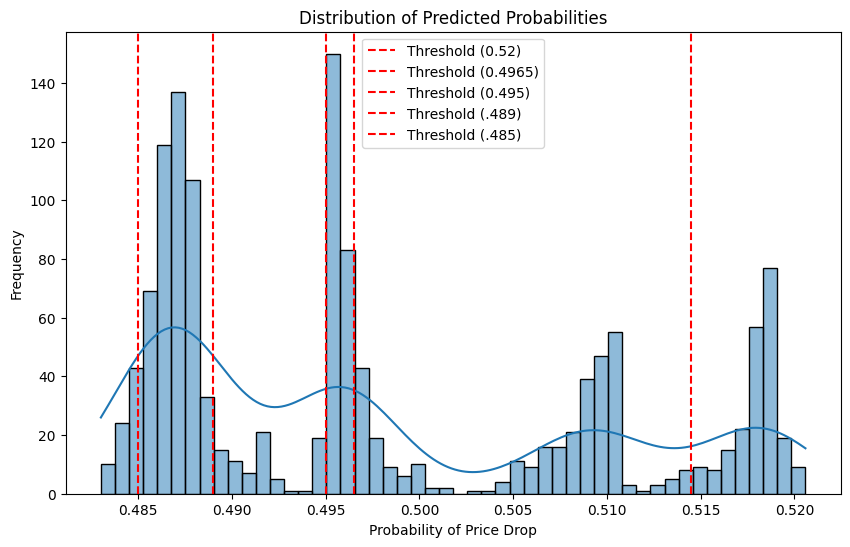

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(y_probs, bins=50, kde=True)
plt.axvline(x=0.5145, color='r', linestyle='--', label='Threshold (0.52)')
plt.axvline(x=.4965, color='r', linestyle='--', label='Threshold (0.4965)')
plt.axvline(x=.495, color='r', linestyle='--', label='Threshold (0.495)')
plt.axvline(x=.489, color='r', linestyle='--', label='Threshold (.489)')
plt.axvline(x=.485, color='r', linestyle='--', label='Threshold (.485)')
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Probability of Price Drop')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [68]:
effective_threshold = y_probs.max() * 0.95  # Use 95% of max observed
effective_threshold

0.494561944944528

In [ ]:
y_probs = model.predict_proba(X)[:, 1]  # Probabilities of class 1 (price drop)

from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
pr_auc = auc(recall, precision)

f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]